<a href="https://colab.research.google.com/github/akiabe/udemy_PyTorch_DNN/blob/master/pytorch_fahion_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [37]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

In [38]:
train_dataset = torchvision.datasets.FashionMNIST(
    root=".",
    train=True,
    transform=transforms.ToTensor(),
    download=True
)

test_dataset = torchvision.datasets.FashionMNIST(
    root=".",
    train=False,
    transform=transforms.ToTensor(),
    download=True
)

In [39]:
train_dataset.data.max()

tensor(255, dtype=torch.uint8)

In [40]:
train_dataset.data.shape

torch.Size([60000, 28, 28])

In [41]:
train_dataset.targets

tensor([9, 0, 0,  ..., 3, 0, 5])

In [42]:
K = len(set(train_dataset.targets.numpy()))
print(f"class numbers : {K}")

class numbers : 10


In [ ]:
# input (N, C_input, H_input, W_input)
# output (N, C_output, H_output, W_output) 
# H_output = floor[H_input + 2*Padding - Dilation * (Kernel_size - 1) - 1 / Stride + 1]
# W_output = floor[H_output + 2*Padding - Dilation * (Kernel_size - 1) - 1 / Stride + 1]

In [43]:
class CNN(nn.Module):
  def __init__(self, K):
    super(CNN, self).__init__()
    self.conv_layers = nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=2),
        nn.ReLU(),
        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2),
        nn.ReLU(),
        nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2),
        nn.ReLU()
    )
    self.dense_layers = nn.Sequential(
        nn.Dropout(0.2),
        nn.Linear(128*2*2, 512),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(512, K)
    )
  def forward(self, X):
    out = self.conv_layers(X)
    out = out.view(out.size(0), -1)
    out = self.dense_layers(out)
    return out

In [44]:
model = CNN(K)

In [45]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)

cuda:0


CNN(
  (conv_layers): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
    (3): ReLU()
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2))
    (5): ReLU()
  )
  (dense_layers): Sequential(
    (0): Dropout(p=0.2, inplace=False)
    (1): Linear(in_features=512, out_features=512, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)

In [46]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [47]:
batch_size = 128
train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True
)
test_loader = torch.utils.data.DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=False
)

In [48]:
def batch_gd(model, criterion, optimizer, train_loader, test_loader, epochs):
  train_losses = np.zeros(epochs)
  test_losses = np.zeros(epochs)

  for it in range(epochs):
    model.train()
    t0 = datetime.now()
    train_loss = []
    for inputs, targets in train_loader:
      inputs, targets = inputs.to(device), targets.to(device)
      optimizer.zero_grad()
      outputs = model(inputs)
      loss = criterion(outputs, targets)
      loss.backward()
      optimizer.step()
      train_loss.append(loss.item())
    train_loss = np.mean(train_loss)

    model.eval()
    test_loss = []
    for inputs, targets in test_loader:
      inputs, targets = inputs.to(device), targets.to(device)
      outputs = model(inputs)
      loss = criterion(outputs, targets)
      test_loss.append(loss.item())
    test_loss = np.mean(test_loss)

    train_losses[it] = train_loss
    test_losses[it] = test_loss

    dt = datetime.now() - t0

    print(f"Epoch {it+1}/{epochs}, Train loss : {train_loss:.4f}, \
            Test loss : {test_loss:.4f}, Duration : {dt}")
    
  return train_losses, test_losses

In [49]:
train_losses, test_losses = batch_gd(
    model, criterion, optimizer, train_loader, test_loader, epochs=15)

Epoch 1/15, Train loss : 0.6551,             Test loss : 0.4717, Duration : 0:00:06.377962
Epoch 2/15, Train loss : 0.4240,             Test loss : 0.3917, Duration : 0:00:06.053576
Epoch 3/15, Train loss : 0.3680,             Test loss : 0.3535, Duration : 0:00:06.149735
Epoch 4/15, Train loss : 0.3306,             Test loss : 0.3450, Duration : 0:00:06.310446
Epoch 5/15, Train loss : 0.3025,             Test loss : 0.3146, Duration : 0:00:06.394802
Epoch 6/15, Train loss : 0.2815,             Test loss : 0.2931, Duration : 0:00:06.363242
Epoch 7/15, Train loss : 0.2636,             Test loss : 0.3185, Duration : 0:00:06.247649
Epoch 8/15, Train loss : 0.2467,             Test loss : 0.2852, Duration : 0:00:06.606539
Epoch 9/15, Train loss : 0.2318,             Test loss : 0.2873, Duration : 0:00:06.323484
Epoch 10/15, Train loss : 0.2176,             Test loss : 0.2887, Duration : 0:00:06.251811
Epoch 11/15, Train loss : 0.2059,             Test loss : 0.2842, Duration : 0:00:06.1950

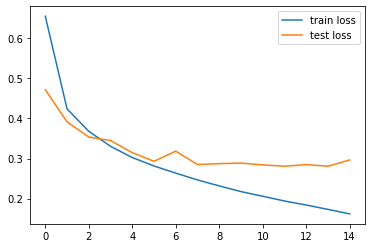

In [50]:
plt.plot(train_losses, label="train loss")
plt.plot(test_losses, label="test loss")
plt.legend()
plt.show()

In [52]:
model.eval()
n_correct = 0
n_total = 0
for inputs, targets in train_loader:
  inputs, targets = inputs.to(device), targets.to(device)
  outputs = model(inputs)
  _, preds = torch.max(outputs, 1)
  n_correct += (preds == targets).sum().item()
  n_total += targets.shape[0]
train_acc = n_correct / n_total

n_correct = 0
n_total = 0
for inputs, targets in test_loader:
  inputs, targets = inputs.to(device), targets.to(device)
  outputs = model(inputs)
  _, preds = torch.max(outputs, 1)
  n_correct += (preds == targets).sum().item()
  n_total += targets.shape[0]
test_acc = n_correct / n_total

print(f"Train acc : {train_acc:.4f}, Test acc : {test_acc:.4f}")

Train acc : 0.9589, Test acc : 0.9035
